In [1]:
# Imporing all required libraries

# Basic Data manupulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Date related functions
import datetime
import os

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Machine learning Models for classification techniques
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Sampling 
from imblearn.over_sampling import SMOTE

In [2]:
# Reading the given data as pandas dataframes
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

# Exploratory Data Analysis

In [3]:
# Checking the dimension of the train data
train.shape

(6439, 16)

The training data has only 16 columns and 6439 rows that is considerably less amount of data provided to us for training our machine learning models, hence we will have to create a cross validation mechanism for checking the efficiency of a model built

In [4]:
# Checking the dimension of the test data
test.shape

(2676, 15)

The test data has 2676 rows that would provide enough data for validating the results of our analysis using the train data

In [5]:
# Taking a look at the training data
train.head()

,L_Id,Date of Creation,Agent Category Assigned,Type of Request,Description of the Request,Location,Street Type,Region Type,Ward No,Estimated Date of Completion,Request Solution Category,Actual Date of Completion,Team Assigned,A_1,A_2,Problem Category
0,LM_1,18-12-2018 00:29,1,10,2,13,11223.0,0,7,18-12-2018 09:29,4,18-12-2018 05:34,45,1,1,1
1,LM_2,30-11-2018 22:19,1,15,17,13,10019.0,0,30,01-12-2018 07:19,8,01-12-2018 00:35,22,2,2,1
2,LM_3,12-12-2018 02:37,1,11,22,0,11237.0,2,7,12-12-2018 11:37,8,12-12-2018 04:29,17,1,1,1
3,LM_4,26-12-2018 01:45,1,11,22,12,11213.0,0,7,26-12-2018 10:45,7,26-12-2018 05:26,33,1,1,1
4,LM_5,24-12-2018 03:22,1,2,27,13,10460.0,0,6,24-12-2018 12:22,4,24-12-2018 10:20,24,0,0,1


From the initial glance at the given data we can notice a few things :

    1. "Date of Creation" and "Actual Date of Completion" columns need to be converted to a proper date format
    2. We can create another columns for time factor in "Date of Creation" and "Actual Date of Completion" for analysing if the time also plays a role in deciding the output
    3. "Street type" column should not be a float value as it only signifies that the street is uphill or downhill
    4. "A_1" and "A_2" columns look exactly same

We will further analyse these assumptions and manupulate the data accordingly, but first we should have a look at the testing data as well

In [6]:
# Taking a look at the test data
test.head()

,L_Id,Date of Creation,Agent Category Assigned,Type of Request,Description of the Request,Location,Street Type,Region Type,Ward No,Estimated Date of Completion,Request Solution Category,Actual Date of Completion,Team Assigned,A_1,A_2
0,LM_19321,03-12-2018 01:30,1,2,31,13,11213.0,0,7,03-12-2018 10:30,8,03-12-2018 06:57,33,1,1
1,LM_19322,12-12-2018 03:22,1,15,6,13,NaN,4,31,12-12-2018 12:22,12,NaN,0,5,5
2,LM_19323,30-12-2018 15:25,1,14,22,13,10027.0,2,30,31-12-2018 00:25,7,30-12-2018 17:01,38,2,2
3,LM_19324,27-12-2018 09:12,1,10,10,13,11385.0,2,38,27-12-2018 18:12,4,27-12-2018 11:34,23,3,3
4,LM_19325,21-12-2018 13:38,1,10,15,13,11217.0,2,7,21-12-2018 22:38,8,21-12-2018 16:08,7,1,1


The assumptions took while having a look at the training data are also present in the training data however we can also see that there is a NaN value present in the data, hence we would check the missing values present in both train and test data

In [7]:
# Checking the missing values in training data
train.isna().sum().sort_values(ascending = False).head()

Actual Date of Completion    432
Street Type                  419
Problem Category               0
A_2                            0
A_1                            0
dtype: int64

As we can see there are null or missing values in 2 columns i.e Actual Date of Completion and Street Type column.
Assumptions:
    
    1. We would assume that where Actual Date of Completion column is null , there the project is yet to be completed or not completed
    2. For null values in Street Type column, we would like to assume that the slanting property of that street is not available to us, hence we would have to further analyse by which method we can impute the missing values in order to increase the efficiency of our predictions
    

In [8]:
# Checking the missing values in test data
test.isna().sum().sort_values(ascending = False).head()

Actual Date of Completion       178
Street Type                     172
Estimated Date of Completion      2
A_2                               0
A_1                               0
dtype: int64

There are again missing values present in the data in columns : Actual Date of Completion, Street Type and Estimated Date of Completion 
    
    1. For the 2 columns similar to the training data we would continue to have the same assumptions, however for the column "Estimated Date of Completion" we would have to further analyse the data available.
        1. Firstly we will have to check if the rows where "Estimated Date of Completion" is null, there the column "Actual Date of Completion" is present or not , on the basis of that we can further make a conclusion that is it a data entry miss or we don't have the clarity on when that particular model is going to end.

In [9]:
## Converting the datatypes of the columns to required format

# converting Object to date
train["Date of Creation"] = pd.to_datetime(train["Date of Creation"]).dt.normalize()
train["Actual Date of Completion"] = pd.to_datetime(train["Actual Date of Completion"]).dt.normalize()
train["Estimated Date of Completion"] = pd.to_datetime(train["Estimated Date of Completion"]).dt.normalize()

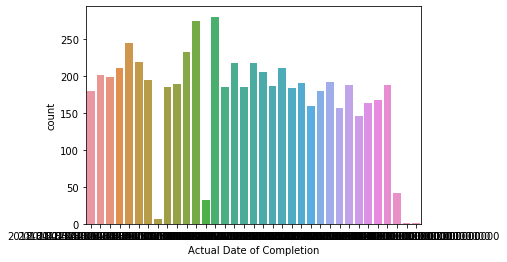

In [10]:
# First we will check and impute missing values for Actual Date of Completion column
sns.countplot(x='Actual Date of Completion',data=train)

As we can see there is no clear pattern in the data however we can see that some values are comparitively much higher than the others while there are some values extremely low and close to 0, they might be outliers but as this is a date column we would rather move ahead with the given data itself
For imputing the missing values we should give the values as "Not available"

In [11]:
# Next I would like to move on to street type column
train["Street Type"].value_counts()

11385.0    125
11368.0    102
11230.0     99
11234.0     87
11209.0     86
          ... 
11040.0      2
11239.0      2
10281.0      1
11109.0      1
10282.0      1
Name: Street Type, Length: 177, dtype: int64

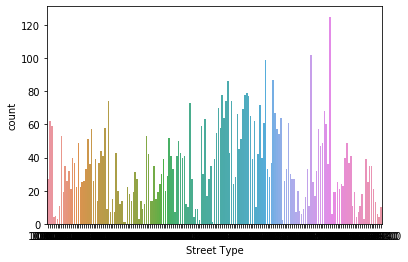

In [12]:
sns.countplot(x='Street Type',data=train)

In [13]:
# As there is no trend in the given data we will impute the values with '0'
train["Street Type"] = train["Street Type"].fillna(0)
test["Street Type"] = test["Street Type"].fillna(0)


In [14]:
# Converting float to Int
train['Street Type'] = train['Street Type'].astype(int)

train.dtypes

L_Id                                    object
Date of Creation                datetime64[ns]
Agent Category Assigned                  int64
Type of Request                          int64
Description of the Request               int64
Location                                 int64
Street Type                              int32
Region Type                              int64
Ward No                                  int64
Estimated Date of Completion    datetime64[ns]
Request Solution Category                int64
Actual Date of Completion       datetime64[ns]
Team Assigned                            int64
A_1                                      int64
A_2                                      int64
Problem Category                         int64
dtype: object

In [15]:
# Checking if each row has a unique id
print(len(train['L_Id']))
print(len(train['L_Id'].unique()))

6439
6439


Each row has a unique id associated to it 

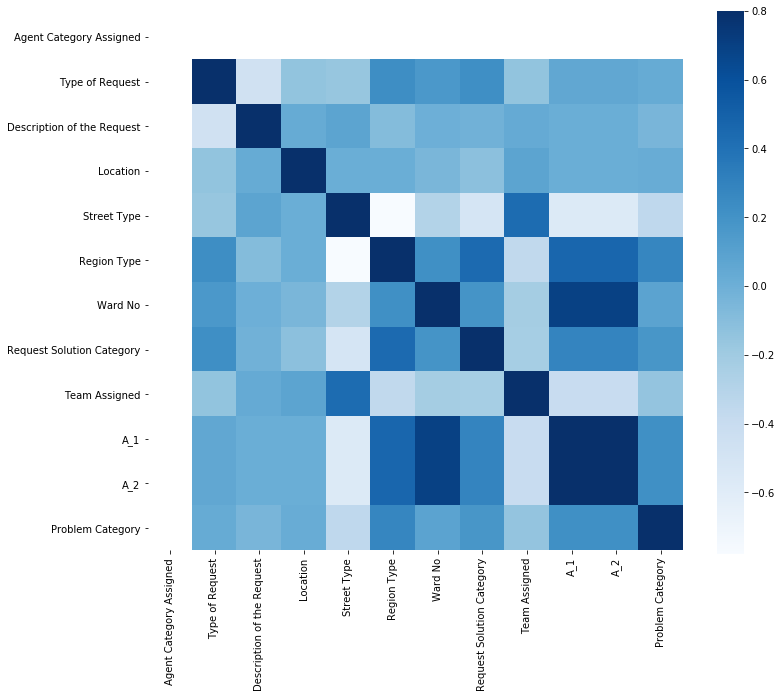

In [16]:
# Let us check how the independent variables are linked to the dependent(target) variable
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, vmax=.8,cmap="Blues", square=True);

Validating our initial assumption that A_1 and A_2 columns are exactly same because of 100% correlation, we can safely remove any one column from the analysis

In [17]:
# Dropping A_1 column from both test and train data
train.drop(["A_1"], axis = 1, inplace = True)
test.drop(["A_1"], axis = 1, inplace = True)

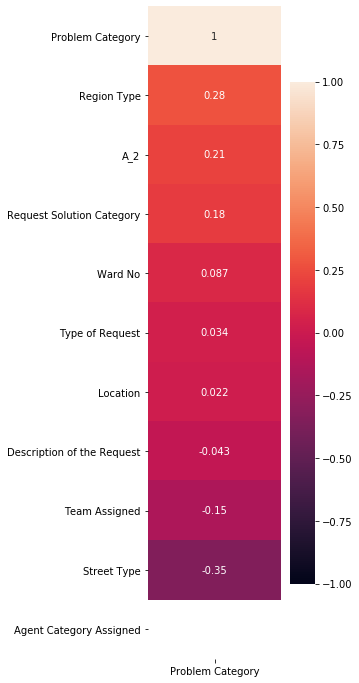

In [18]:
## Checking the importance of each variable by checking correlation with the target variable
plt.figure(figsize=(3,12))
sns.heatmap(train.corr()[['Problem Category']].sort_values(by=['Problem Category'],ascending=False).head(50), vmin=-1, annot=True);

In [19]:
train.dtypes

L_Id                                    object
Date of Creation                datetime64[ns]
Agent Category Assigned                  int64
Type of Request                          int64
Description of the Request               int64
Location                                 int64
Street Type                              int32
Region Type                              int64
Ward No                                  int64
Estimated Date of Completion    datetime64[ns]
Request Solution Category                int64
Actual Date of Completion       datetime64[ns]
Team Assigned                            int64
A_2                                      int64
Problem Category                         int64
dtype: object

In [20]:
## Checking for outliers in the data

int_variable_list=['Agent Category Assigned','Type of Request','Description of the Request','Location','Region Type','Ward No','Request Solution Category','Team Assigned','A_2']

z_score_calc = train[int_variable_list]
# Calculating z score
z = np.abs(stats.zscore(z_score_calc))
# print(z)
print(np.where(z > 4))

(array([], dtype=int64), array([], dtype=int64))


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


There are no significant outliers present in the given data

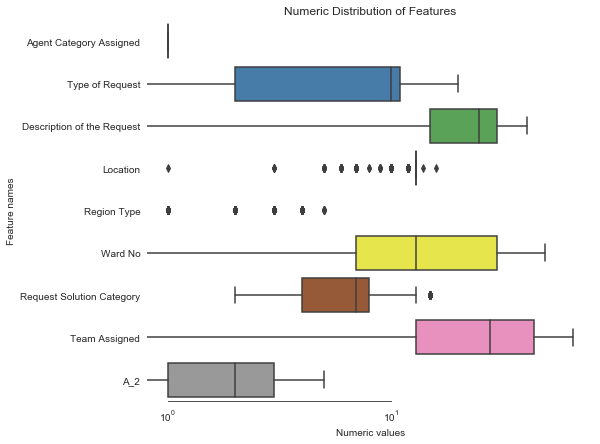

In [21]:
## Checking the skewness of the numeric columns
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=train[int_variable_list] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [22]:
# Find skewed numerical features
skew_features = train[int_variable_list].apply(lambda x: skew(x)).sort_values(ascending=False)

# Features with high skewness
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 1 numerical features with Skew > 0.5 :


Region Type                   2.008863
A_2                           0.487225
Ward No                       0.476131
Request Solution Category     0.414269
Type of Request               0.030378
Team Assigned                 0.006707
Agent Category Assigned       0.000000
Description of the Request   -0.469468
Location                     -3.485294
dtype: float64

we can validate the initial assumption that location and region type will highly influence the data

1    6001
2     301
0     137
Name: Problem Category, dtype: int64


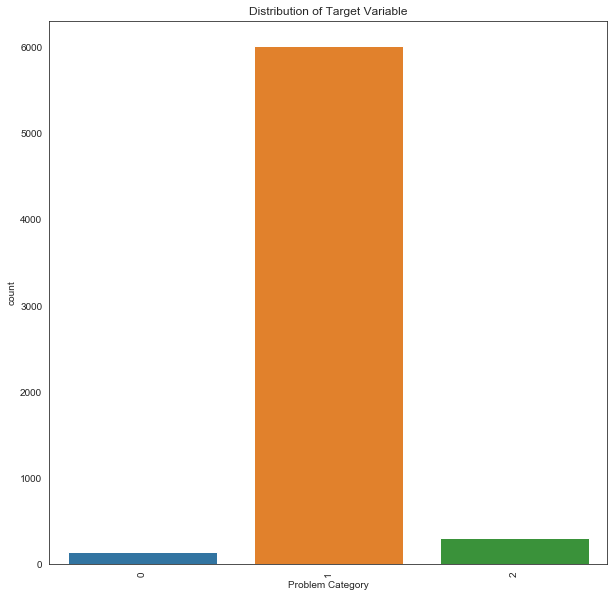

In [23]:
## Checking the target variable distribution
print(train['Problem Category'].value_counts())
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.title('Distribution of Target Variable')
sns.countplot(x='Problem Category',data=train)

As we can see the target distribution is highly skewed towards the value 1, hence we will have to sample the training data differently in order to have a balanced dataset and then the model will be able to predict the values correctly

In [24]:
train.dtypes

L_Id                                    object
Date of Creation                datetime64[ns]
Agent Category Assigned                  int64
Type of Request                          int64
Description of the Request               int64
Location                                 int64
Street Type                              int32
Region Type                              int64
Ward No                                  int64
Estimated Date of Completion    datetime64[ns]
Request Solution Category                int64
Actual Date of Completion       datetime64[ns]
Team Assigned                            int64
A_2                                      int64
Problem Category                         int64
dtype: object

In [25]:
X = train[int_variable_list]
y = train['Problem Category']

In [26]:
# Modelling
# Creating the variables for model fitting
X = train[int_variable_list]
y = train['Problem Category']

# Test variable
test = test.drop(columns=['L_Id'])

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .3, random_state=0)

In [28]:
print("Before OverSampling, counts of label '2': {}".format(sum(y_train == 2)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
 
sm = SMOTE(random_state = 3) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2))) 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '2': 224
Before OverSampling, counts of label '1': 4197
Before OverSampling, counts of label '0': 86 

After OverSampling, the shape of train_X: (12591, 9)
After OverSampling, the shape of train_y: (12591,) 

After OverSampling, counts of label '2': 4197
After OverSampling, counts of label '1': 4197
After OverSampling, counts of label '0': 4197


In [29]:
## Modelling
## Using Random Forest Model to predict the target value on test data
## This line instantiates the model. ## This  
rf = RandomForestClassifier() 
## Fit the model on your training data.
rf.fit(X_train_res, y_train_res) 
## And score it on your testing data.
rf.score(X_test, y_test)

0.9658385093167702

In [33]:
test = pd.read_csv('Test.csv')
test_for_pred = test[int_variable_list]
prediction_rf = rf.predict(test_for_pred)

In [34]:
df_rf=pd.DataFrame()
df_rf['L_Id']=test['L_Id']
df_rf['Problem Category']=prediction_rf

In [36]:
## LightGBM classifier
lgbc = lgb.LGBMClassifier(learning_rate = 0.125, 
                        n_estimators = 20, num_leaves = 38)
lgbc.fit(X_train_res, y_train_res) 
lgbc.score(X_test, y_test)

0.9648033126293996

In [37]:
prediction_lgb = lgbc.predict(test_for_pred)

In [38]:
df_lgb=pd.DataFrame()
df_lgb['L_Id']=test['L_Id']
df_lgb['Problem Category']=prediction_lgb

In [39]:
## XGBoost Classifier
xgbc = XGBClassifier()
xgbc.fit(X_train_res, y_train_res) 
xgbc.score(X_test, y_test)

0.9658385093167702

In [40]:
prediction_xgb = xgbc.predict(test_for_pred)

In [41]:
df_xgb=pd.DataFrame()
df_xgb['L_Id']=test['L_Id']
df_xgb['Problem Category']=prediction_xgb

In [44]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return (((0.3 * rf.predict(X)) + \
            (0.3 * lgbc.predict(X)) + \
            (0.4 * xgbc.predict((X)))))

In [45]:
final_predictions  = blended_predictions(test_for_pred)

In [46]:
df_blended=pd.DataFrame()
df_blended['L_Id']=test['L_Id']
df_blended['Problem Category']=final_predictions